
## 02 - RNN Baseline Training
# Notebook scope:
- reuse the prepared embeddings and tokenised data
- train a simple RNN classifier with pooled sentence representations
- explore regularisation strategies and sentence representation variants
- report validation curves, best config, and topic-wise accuracy

## Imports & data setup

In [22]:
from dataclasses import replace
from pathlib import Path
import random
from textwrap import shorten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, colors
from IPython.display import Markdown, display

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report
from src.training import RNNExperimentConfig, train_rnn_model
from src.evaluation import (
    evaluate_model,
    topic_accuracy_table,
    classification_report_table,
)
from src.plotting import plot_training_curves
import torch


In [23]:

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
sns.set_theme(style="whitegrid")

data_config = load_data_config(Path("configs/data.yaml"))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)

(4361, 1091, 500)

## Embedding prep

In [24]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)

embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name="6B",
    dim=100,
    trainable=True,
    random_seed=7,
)

## Baseline configuration

In [25]:
baseline_config = RNNExperimentConfig(
    epochs=40,
    batch_size=64,
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    learning_rate=1e-3,
    weight_decay=0.0,
    grad_clip=1.0,
    pooling="last_hidden",
    optimizer="adam",
    early_stopping_patience=3,
)

## Train baseline RNN

In [26]:
history, model, label_to_index, dataloaders = train_rnn_model(
    config=baseline_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
)
index_to_label = {idx: label for label, idx in label_to_index.items()}
history.best_epoch, len(history.train_loss)

(28, 31)

## Training curves

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

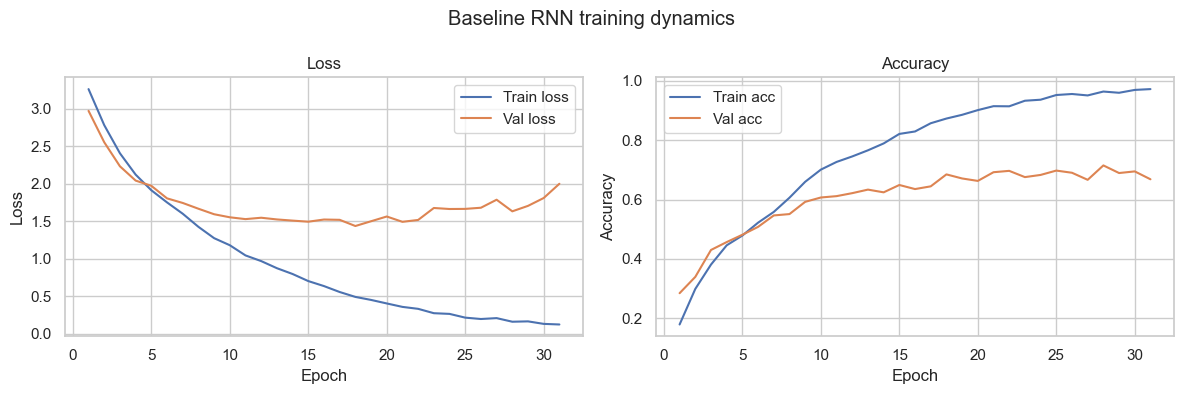

In [27]:
plot_training_curves(
    history,
    title="Baseline RNN training dynamics",
    output_path=Path("plots/part2_rnn_baseline_curves.png"),
)

## Validation & test metrics

In [28]:
val_eval = evaluate_model(model, dataloaders.validation)
test_eval = evaluate_model(model, dataloaders.test)

baseline_metrics = pd.DataFrame(
    [
        {"split": "validation", "loss": val_eval.loss, "accuracy": val_eval.accuracy},
        {"split": "test", "loss": test_eval.loss, "accuracy": test_eval.accuracy},
    ]
)
baseline_metrics

,split,loss,accuracy
0,validation,2.000499,0.668194
1,test,1.545944,0.718000


/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_44990/1286053093.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'), norm=norm)


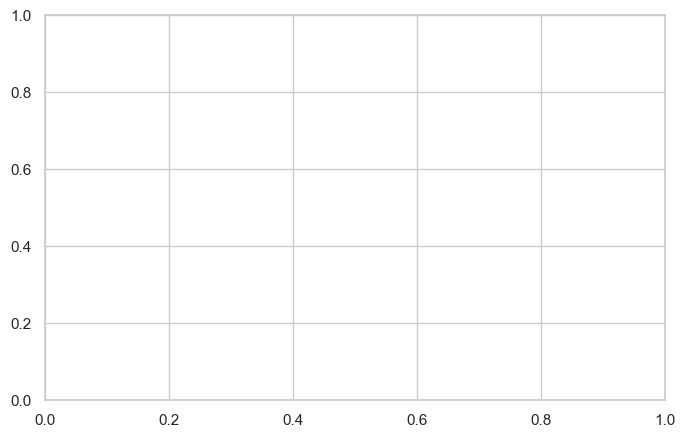

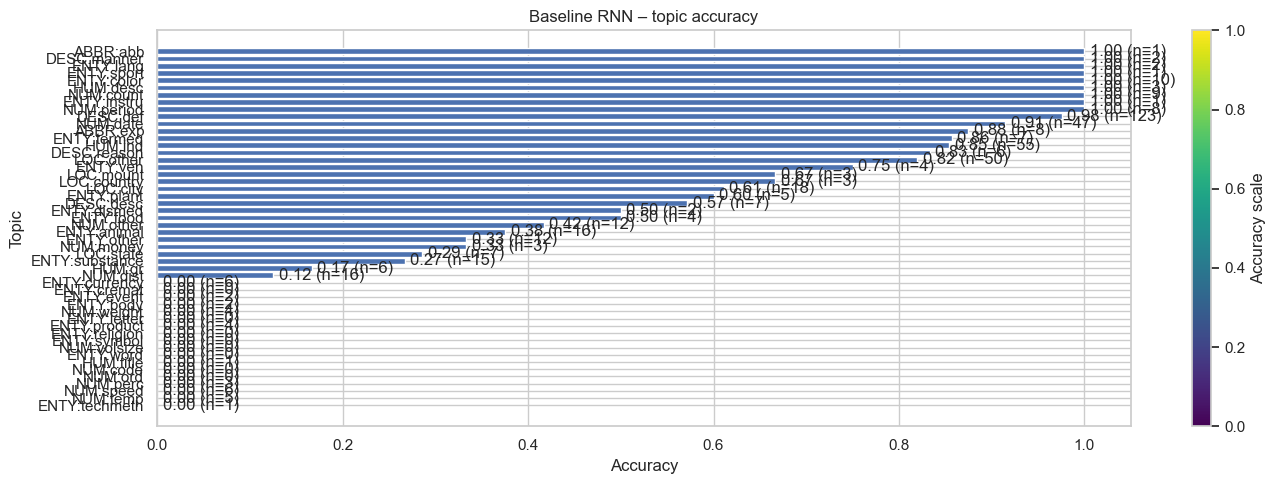

In [ ]:
topic_accuracy_df = topic_accuracy_table(test_eval, index_to_label)
sorted_topics = topic_accuracy_df.sort_values('accuracy')
fig, ax = plt.subplots(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.barh(sorted_topics['label'], sorted_topics['accuracy'])
ax.set_xlabel('Accuracy')
ax.set_ylabel('Topic')
ax.set_title('Baseline RNN – topic accuracy')
ax.set_xlim(0, 1.05)
ax.bar_label(bars, labels=[f"{acc:.2f} (n={supp})" for acc, supp in zip(sorted_topics['accuracy'], sorted_topics['support'])], padding=4)
norm = colors.Normalize(0, 1)
sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'), norm=norm)
sm.set_array([])
plt.tight_layout()
fig.savefig('plots/part2_topic_accuracy.png', dpi=300)
plt.show()


/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_44990/2448361559.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  support_colors = [cm.get_cmap('magma')(acc) for acc in baseline_label_rows['accuracy'].clip(0, 1)]
/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_44990/2448361559.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = cm.ScalarMappable(cmap=cm.get_cmap('magma'), norm=colors.Normalize(0, 1))


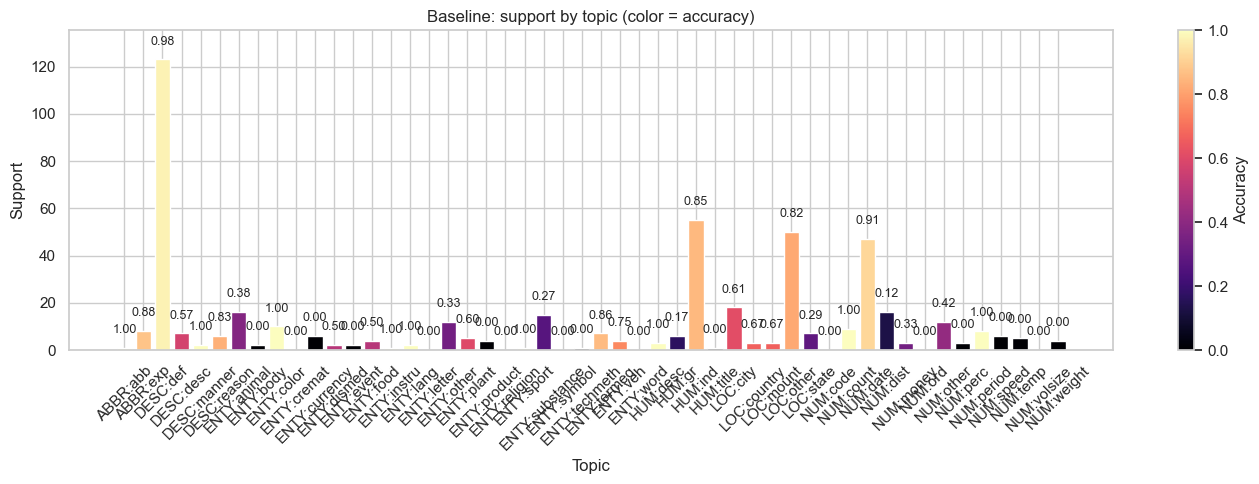

/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_44990/2448361559.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  f1_colors = [cm.get_cmap('plasma')(score) for score in baseline_label_rows['f1-score'].clip(0, 1)]


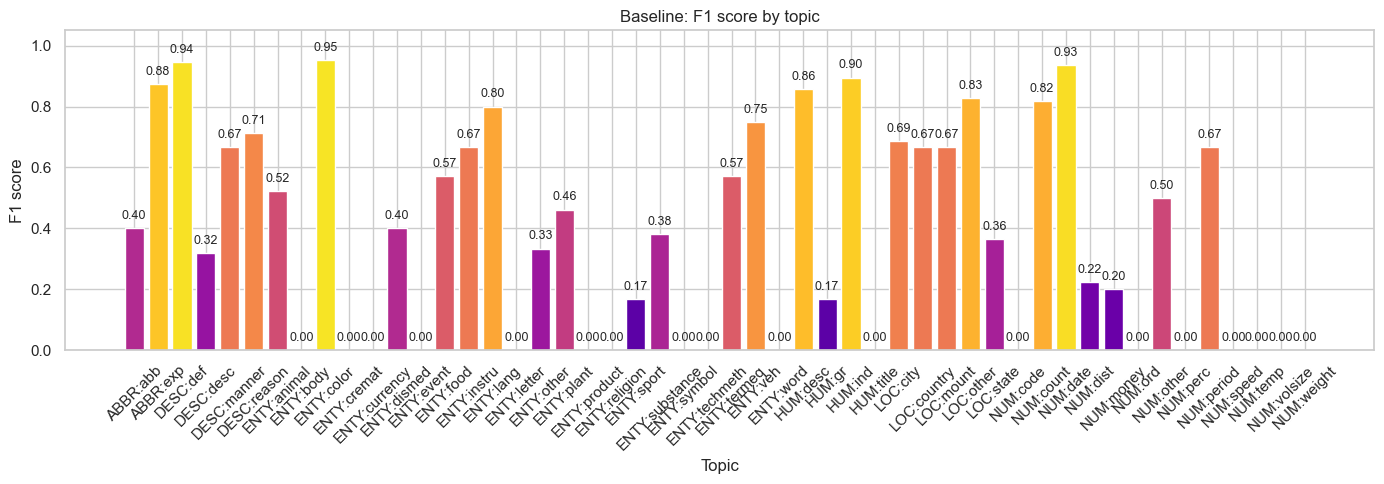

In [30]:
baseline_report_df = classification_report_table(test_eval, index_to_label)
baseline_label_rows = baseline_report_df.loc[
    ~baseline_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])
].copy()
if 'accuracy' not in baseline_label_rows.columns:
    baseline_label_rows['accuracy'] = baseline_label_rows.get('recall', 0.0)

fig, ax = plt.subplots(figsize=(14, 5))
support_colors = [cm.get_cmap('magma')(acc) for acc in baseline_label_rows['accuracy'].clip(0, 1)]
bars = ax.bar(baseline_label_rows.index, baseline_label_rows['support'], color=support_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('Support')
ax.set_title('Baseline: support by topic (color = accuracy)')
ax.set_ylim(0, baseline_label_rows['support'].max() * 1.1)
for bar, accuracy in zip(bars, baseline_label_rows['accuracy']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=9)
sm = cm.ScalarMappable(cmap=cm.get_cmap('magma'), norm=colors.Normalize(0, 1))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('plots/part2_classification_support.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(14, 5))
f1_colors = [cm.get_cmap('plasma')(score) for score in baseline_label_rows['f1-score'].clip(0, 1)]
bars = ax.bar(baseline_label_rows.index, baseline_label_rows['f1-score'], color=f1_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('F1 score')
ax.set_title('Baseline: F1 score by topic')
ax.set_ylim(0, 1.05)
for bar, score in zip(bars, baseline_label_rows['f1-score']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('plots/part2_classification_f1.png', dpi=300)
plt.show()


## OOV initialization strategy comparison


In [31]:
strategies = ["sif", "mean", "zero"]
strategy_histories = {}
strategy_models = {}

for strategy in strategies:
    print(f"Training with {strategy} strategy...")
    embedding_result = load_torchtext_glove(
        vocabulary=vocab_report.vocabulary,
        name="6B",
        dim=100,
        trainable=True,
        random_seed=SEED,
        oov_strategy=strategy,
    )
    
    history, model, _, _ = train_rnn_model(
        config=baseline_config,
        splits=splits,
        vocabulary=vocab_report.vocabulary,
        embedding_result=embedding_result,
    )
    
    strategy_histories[strategy] = history
    strategy_models[strategy] = model


Training with sif strategy...
Training with mean strategy...
Training with zero strategy...


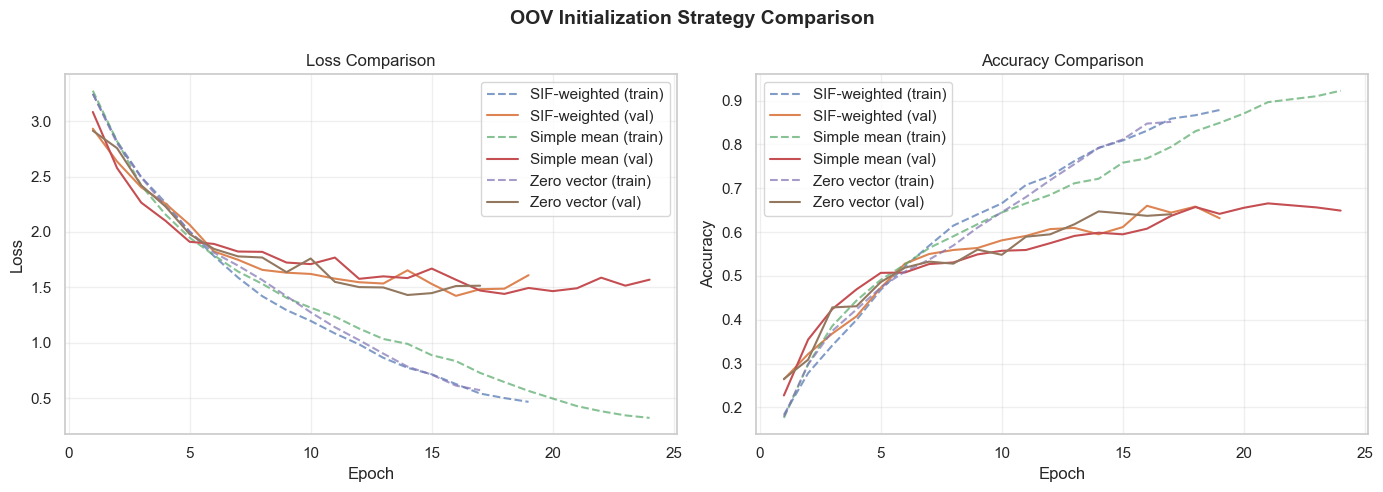

Best validation accuracies:
  sif   : 0.6599
  mean  : 0.6654
  zero  : 0.6471


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for strategy in strategies:
    h = strategy_histories[strategy]
    epochs = range(1, len(h.train_loss) + 1)
    label = {"sif": "SIF-weighted", "mean": "Simple mean", "zero": "Zero vector"}[strategy]
    axes[0].plot(epochs, h.train_loss, label=f"{label} (train)", linestyle="--", alpha=0.7)
    axes[0].plot(epochs, h.val_loss, label=f"{label} (val)", linestyle="-")
    axes[1].plot(epochs, h.train_accuracy, label=f"{label} (train)", linestyle="--", alpha=0.7)
    axes[1].plot(epochs, h.val_accuracy, label=f"{label} (val)", linestyle="-")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Comparison")
axes[0].legend(loc="best")
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Comparison")
axes[1].legend(loc="best")
axes[1].grid(True, alpha=0.3)

fig.suptitle("OOV Initialization Strategy Comparison", fontsize=14, fontweight="bold")
fig.tight_layout()
fig.savefig("plots/oov_strategy_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("Best validation accuracies:")
for strategy in strategies:
    h = strategy_histories[strategy]
    best_val_acc = max(h.val_accuracy) if h.val_accuracy else 0.0
    print(f"  {strategy:6s}: {best_val_acc:.4f}")


## Regularisation comparison

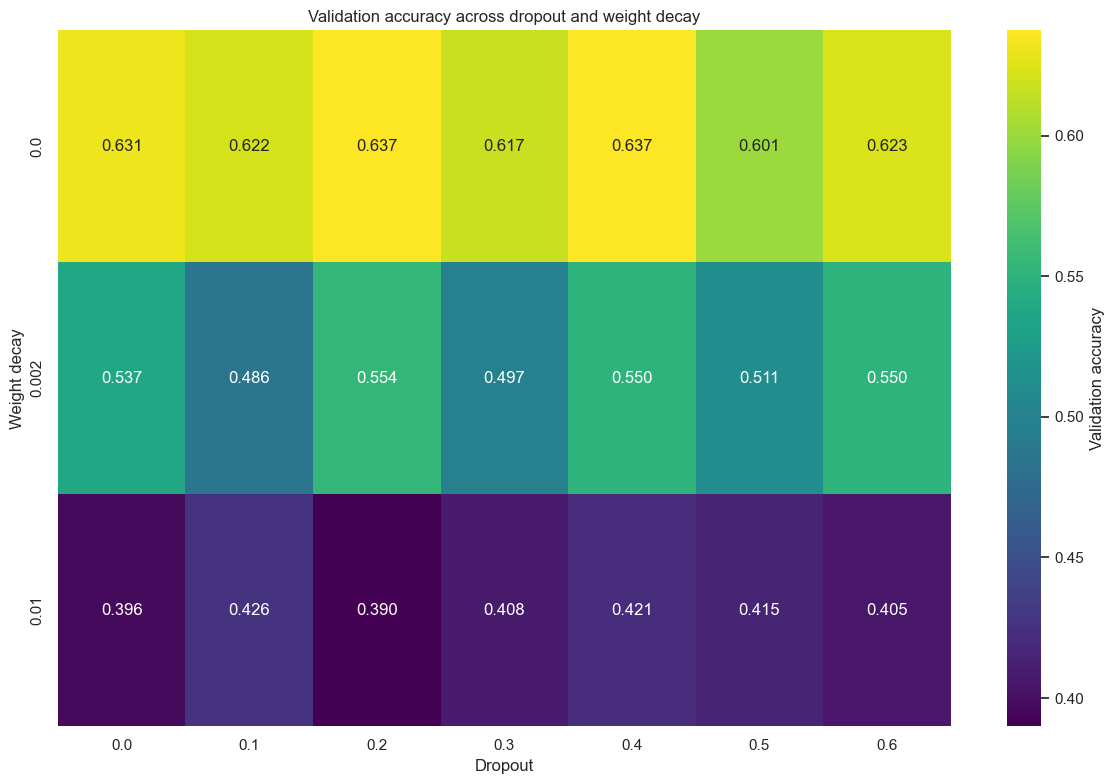

,name,dropout,weight_decay,grad_clip,best_epoch,val_accuracy,test_accuracy
2,dropout_0.00_wd_6e-06,0.0,0.000,1.0,15,0.668,0.692
7,dropout_0.10_wd_0e+00,0.1,0.000,1.0,15,0.629,0.688
23,dropout_0.30_wd_6e-06,0.3,0.000,1.0,15,0.636,0.684
3,dropout_0.00_wd_4e-05,0.0,0.000,1.0,14,0.647,0.678
9,dropout_0.10_wd_6e-06,0.1,0.000,1.0,15,0.648,0.678
10,dropout_0.10_wd_4e-05,0.1,0.000,1.0,15,0.624,0.678
28,dropout_0.40_wd_0e+00,0.4,0.000,1.0,15,0.675,0.678
8,dropout_0.10_wd_1e-06,0.1,0.000,1.0,14,0.643,0.676
15,dropout_0.20_wd_1e-06,0.2,0.000,1.0,15,0.651,0.670
37,dropout_0.50_wd_6e-06,0.5,0.000,1.0,13,0.618,0.668


In [25]:
dropout_grid = np.linspace(0.0, 0.6, 7)
weight_decay_grid = np.concatenate(([0.0], np.logspace(-6, -2, 6)))

regularisation_variants = []
for dropout in dropout_grid:
    for weight_decay in weight_decay_grid:
        cfg = replace(
            baseline_config,
            dropout=float(dropout),
            weight_decay=float(weight_decay),
        )
        name = f"dropout_{dropout:.2f}_wd_{weight_decay:.0e}"
        regularisation_variants.append((name, cfg))

reg_results = []
for name, cfg in regularisation_variants:
    hist, mdl, _, loaders = train_rnn_model(
        config=cfg,
        splits=splits,
        vocabulary=vocab_report.vocabulary,
        embedding_result=embedding_result,
    )
    val_res = evaluate_model(mdl, loaders.validation)
    test_res = evaluate_model(mdl, loaders.test)
    reg_results.append(
        {
            "name": name,
            "dropout": float(f"{cfg.dropout:.3f}"),
            "weight_decay": float(f"{cfg.weight_decay:.3f}"),
            "grad_clip": float(f"{cfg.grad_clip:.3f}"),
            "best_epoch": int(hist.best_epoch),
            "val_accuracy": float(f"{val_res.accuracy:.3f}"),
            "test_accuracy": float(f"{test_res.accuracy:.3f}"),
        }
    )

regularisation_df = pd.DataFrame(reg_results).sort_values(
    "test_accuracy", ascending=False
)

heatmap_data = (
    regularisation_df
    .pivot_table(index="weight_decay", columns="dropout", values="val_accuracy")
    .sort_index()
    .sort_index(axis=1)
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={"label": "Validation accuracy"},
)
plt.title("Validation accuracy across dropout and weight decay")
plt.xlabel("Dropout")
plt.ylabel("Weight decay")
plt.tight_layout()
plt.savefig('part2_heatmap.png')
plt.show()

regularisation_df


In [26]:
best_regulariser = regularisation_df.iloc[0]
control_row = regularisation_df.loc[

    (regularisation_df["dropout"] == 0.0)
    & (regularisation_df["weight_decay"] == 0.0)
].iloc[0]
display(pd.DataFrame([best_regulariser, control_row]))


,name,dropout,weight_decay,grad_clip,best_epoch,val_accuracy,test_accuracy
2,dropout_0.00_wd_6e-06,0.0,0.0,1.0,15,0.668,0.692
2,dropout_0.00_wd_6e-06,0.0,0.0,1.0,15,0.668,0.692


## Sentence representation strategies

In [27]:
pooling_options = ["last_hidden", "mean", "max", "attention"]
pooling_results = []

for pooling in pooling_options:
    cfg = replace(baseline_config, pooling=pooling)
    hist, mdl, _, loaders = train_rnn_model(
        config=cfg,
        splits=splits,
        vocabulary=vocab_report.vocabulary,
        embedding_result=embedding_result,
    )
    test_res = evaluate_model(mdl, loaders.test)
    pooling_results.append(
        {
            "pooling": pooling,
            "best_epoch": hist.best_epoch,
            "test_accuracy": test_res.accuracy,
        }
    )

pooling_df = pd.DataFrame(pooling_results).sort_values(
    "test_accuracy", ascending=False
)
pooling_df

,pooling,best_epoch,test_accuracy
2,max,14,0.784
3,attention,14,0.784
1,mean,15,0.712
0,last_hidden,15,0.672


In [28]:
best_pooling = pooling_df.iloc[0]
display(best_pooling.to_frame().T)


,pooling,best_epoch,test_accuracy
2,max,14,0.784


## Best configuration evaluation


In [29]:
best_config = replace(
    baseline_config,
    dropout=float(best_regulariser['dropout']),
    weight_decay=float(best_regulariser['weight_decay']),
    grad_clip=float(best_regulariser['grad_clip']),
    pooling=str(best_pooling['pooling']),
)
best_history, best_model, best_label_to_index, best_dataloaders = train_rnn_model(
    config=best_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
)
best_val_eval = evaluate_model(best_model, best_dataloaders.validation)
best_test_eval = evaluate_model(best_model, best_dataloaders.test)
best_index_to_label = {idx: label for label, idx in best_label_to_index.items()}
display(Markdown(f"Best config uses pooling={best_config.pooling}, dropout={best_config.dropout}, weight_decay={best_config.weight_decay}, grad_clip={best_config.grad_clip}."))


Best config uses pooling=max, dropout=0.0, weight_decay=0.0, grad_clip=1.0.

(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

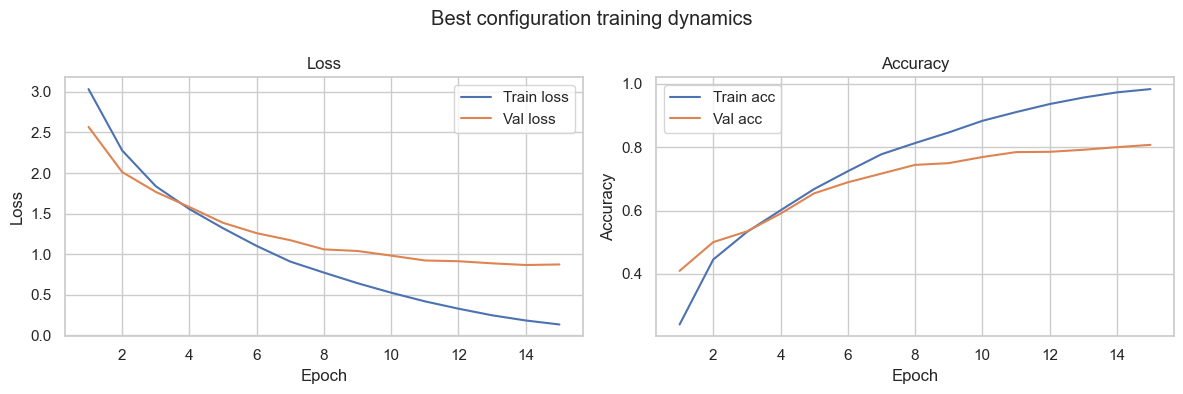

In [30]:
plot_training_curves(
    best_history,
    title="Best configuration training dynamics",
    output_path=Path("plots/part2_best_rnn_curves.png"),
)


### Topic-wise accuracy (best configuration)


/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_75957/2705653629.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'), norm=norm)


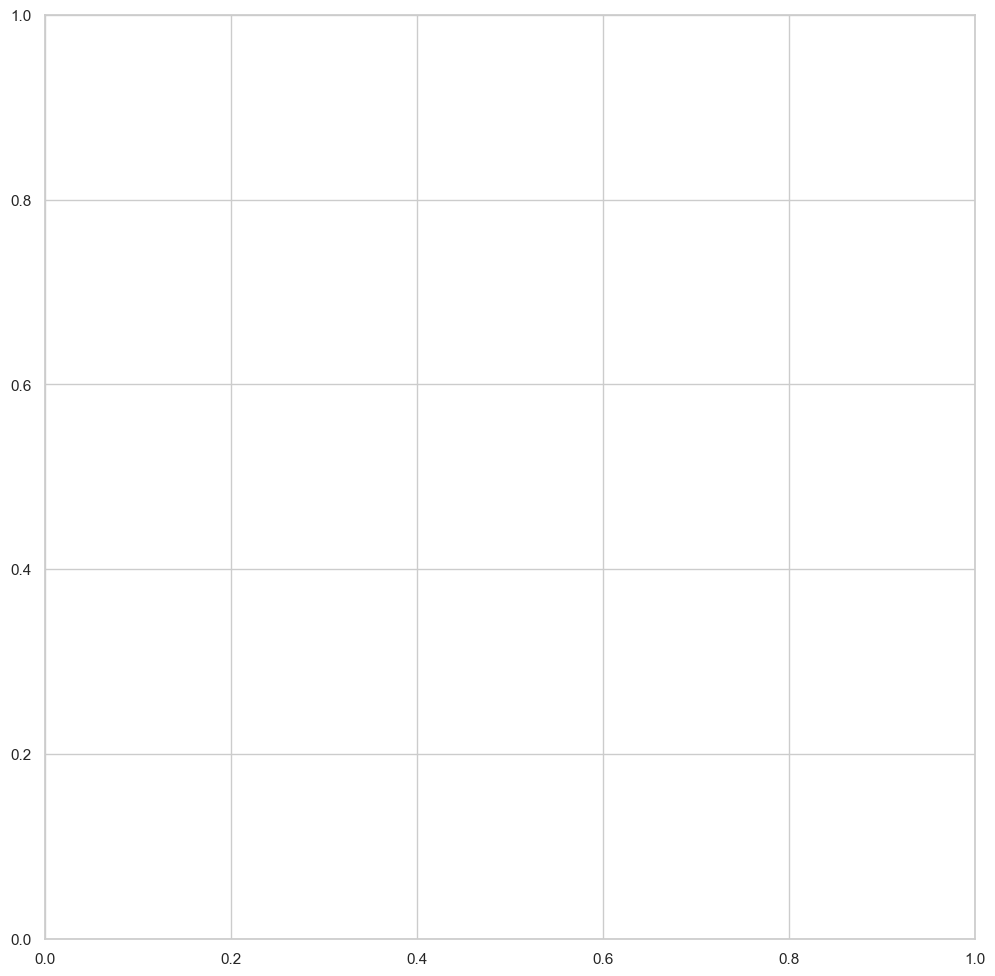

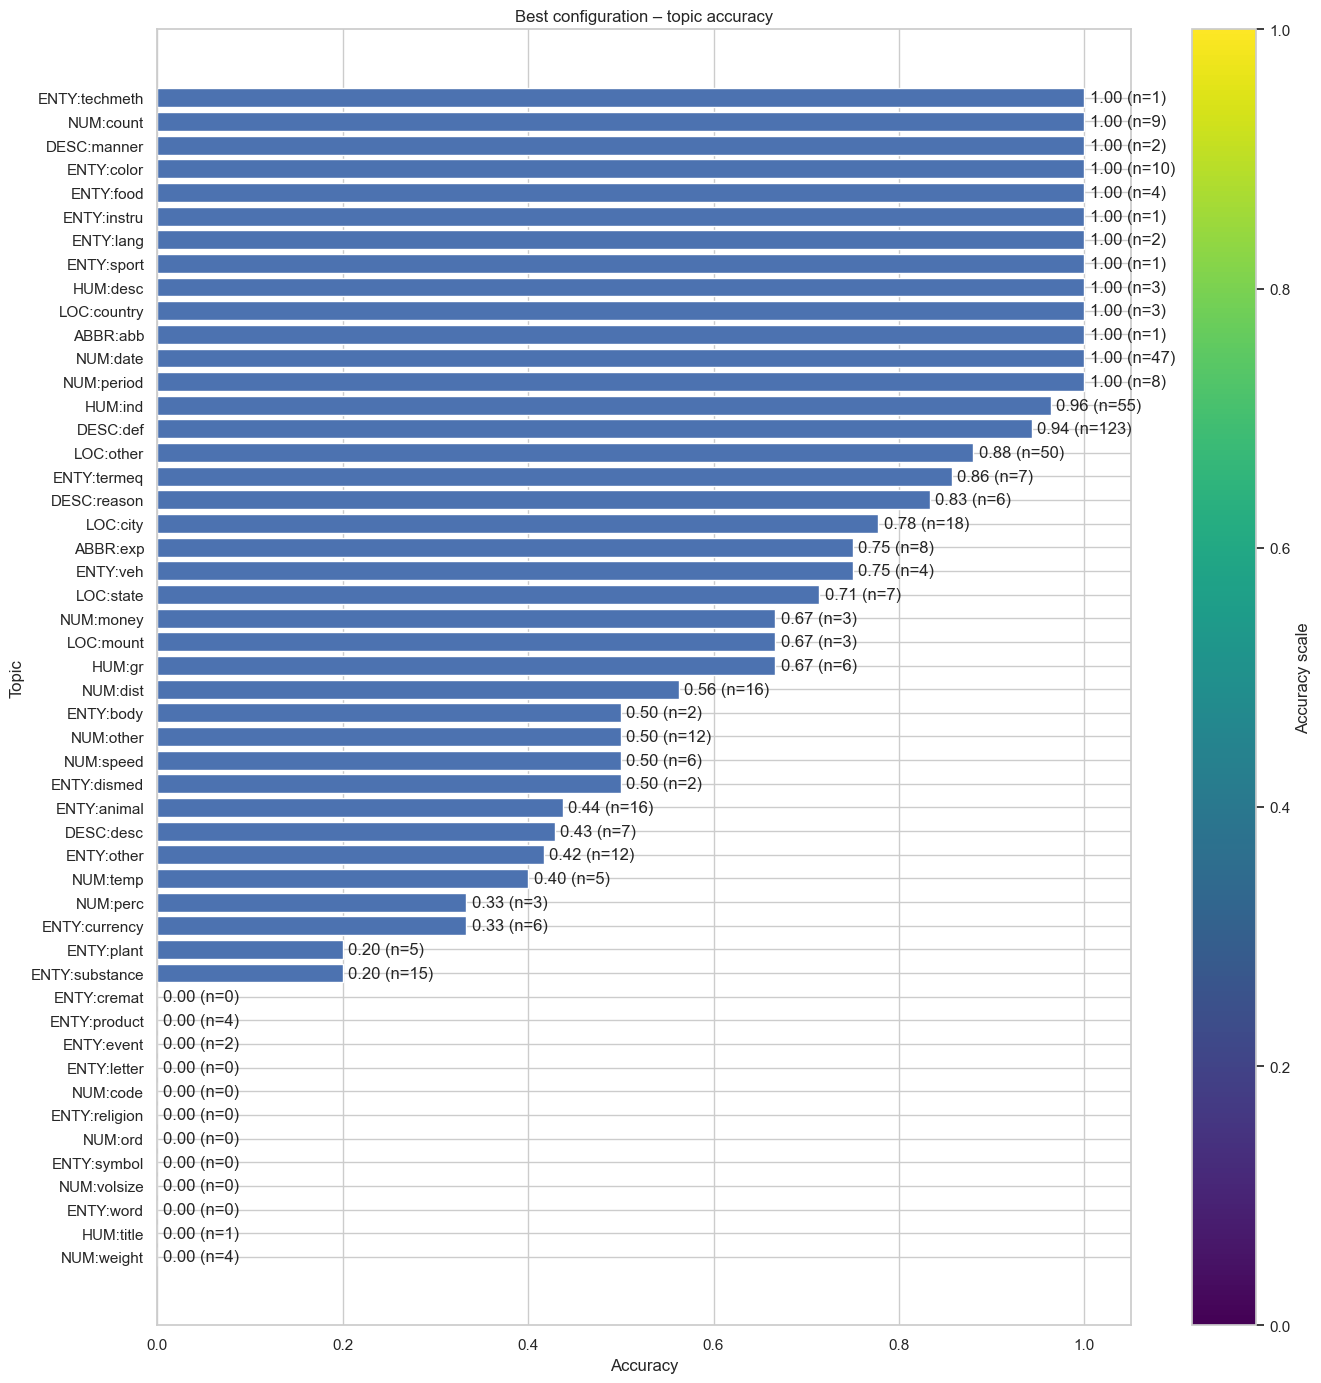

In [31]:
best_topic_accuracy_df = topic_accuracy_table(best_test_eval, best_index_to_label)
sorted_best_topics = best_topic_accuracy_df.sort_values('accuracy')
fig, ax = plt.subplots(figsize=(12, 12))
fig, ax = plt.subplots(figsize=(14, 14))
bars = ax.barh(sorted_best_topics['label'], sorted_best_topics['accuracy'])
ax.set_xlabel('Accuracy')
ax.set_ylabel('Topic')
ax.set_title('Best configuration – topic accuracy')
ax.set_xlim(0, 1.05)
ax.bar_label(bars, labels=[f"{acc:.2f} (n={supp})" for acc, supp in zip(sorted_best_topics['accuracy'], sorted_best_topics['support'])], padding=4)
norm = colors.Normalize(0, 1)
sm = cm.ScalarMappable(cmap=cm.get_cmap('viridis'), norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy scale')
plt.tight_layout()
fig.savefig('plots/part2_best_topic_accuracy.png', dpi=300)
plt.show()


### Classification report (best configuration)


In [32]:
best_class_report_df = classification_report_table(best_test_eval, best_index_to_label)
best_label_rows = best_class_report_df.loc[
    ~best_class_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])
].copy()
if 'accuracy' not in best_label_rows.columns:
    best_label_rows['accuracy'] = best_label_rows.get('recall', 0.0)


/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_75957/2779192642.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  support_colors = [cm.get_cmap('magma')(acc) for acc in best_label_rows['accuracy'].clip(0, 1)]
/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_75957/2779192642.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('magma'), norm=colors.Normalize(0, 1))


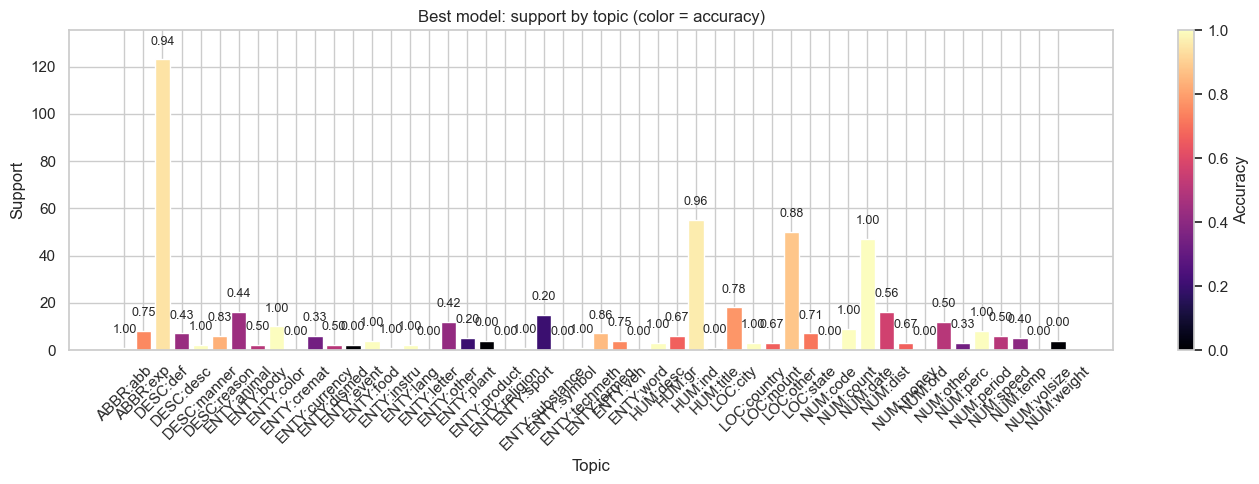

In [33]:
fig, ax = plt.subplots(figsize=(14, 5))
support_colors = [cm.get_cmap('magma')(acc) for acc in best_label_rows['accuracy'].clip(0, 1)]
bars = ax.bar(best_label_rows.index, best_label_rows['support'], color=support_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('Support')
ax.set_title('Best model: support by topic (color = accuracy)')
ax.set_ylim(0, best_label_rows['support'].max() * 1.1)
for bar, accuracy in zip(bars, best_label_rows['accuracy']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=9)
sm = plt.cm.ScalarMappable(cmap=cm.get_cmap('magma'), norm=colors.Normalize(0, 1))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('plots/part2_best_classification_support.png', dpi=300)
plt.show()


/var/folders/pg/r4yzns2j5_j_wslh07jkrbcr0000gn/T/ipykernel_75957/562655982.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  f1_colors = [cm.get_cmap('plasma')(score) for score in best_label_rows['f1-score'].clip(0, 1)]


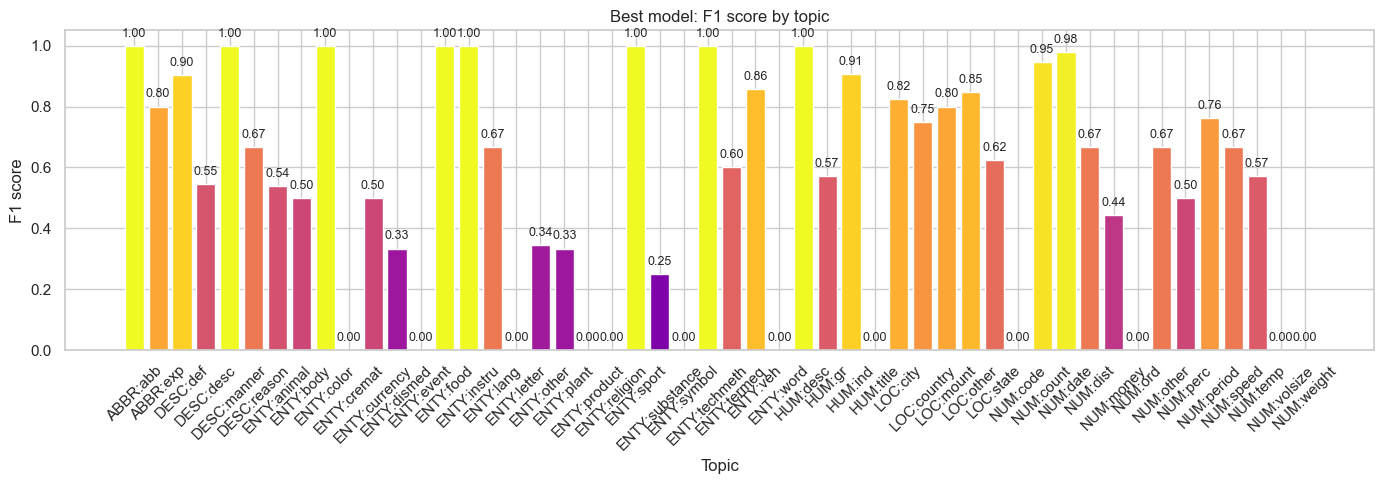

In [34]:
fig, ax = plt.subplots(figsize=(14, 5))
f1_colors = [cm.get_cmap('plasma')(score) for score in best_label_rows['f1-score'].clip(0, 1)]
bars = ax.bar(best_label_rows.index, best_label_rows['f1-score'], color=f1_colors)
ax.set_xlabel('Topic')
ax.set_ylabel('F1 score')
ax.set_title('Best model: F1 score by topic')
ax.set_ylim(0, 1.05)
for bar, score in zip(bars, best_label_rows['f1-score']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('plots/part2_best_classification_f1.png', dpi=300)
plt.show()


In [35]:
best_averages_df = best_class_report_df.loc[
    ['accuracy', 'macro avg', 'weighted avg'],
    [col for col in best_class_report_df.columns if col in ['precision', 'recall', 'f1-score']],
]
best_averages_df


,precision,recall,f1-score
accuracy,0.792000,0.792000,0.79200
macro avg,0.597873,0.555623,0.54730
weighted avg,0.797539,0.792000,0.77693


In [36]:
lowest_best_topics = best_topic_accuracy_df.sort_values('accuracy').head(2)
notes = ', '.join(f"{row.label} ({row.accuracy:.2f})" for row in lowest_best_topics.itertuples())
display(Markdown(f"Best model weakest topics: {notes}."))


Best model weakest topics: NUM:weight (0.00), HUM:title (0.00).

## Summary

In [37]:
summary = pd.DataFrame(
    [
        {
            'epochs': best_config.epochs,
            'batch_size': best_config.batch_size,
            'optimizer': best_config.optimizer,
            'learning_rate': best_config.learning_rate,
            'hidden_dim': best_config.hidden_dim,
            'num_layers': best_config.num_layers,
            'dropout': best_config.dropout,
            'weight_decay': best_config.weight_decay,
            'grad_clip': best_config.grad_clip,
            'pooling': best_config.pooling,
            'best_epoch': best_history.best_epoch,
            'val_accuracy': best_val_eval.accuracy,
            'test_accuracy': best_test_eval.accuracy,
        }
    ]
)
summary


,epochs,batch_size,optimizer,learning_rate,hidden_dim,num_layers,dropout,weight_decay,grad_clip,pooling,best_epoch,val_accuracy,test_accuracy
0,15,64,adam,0.001,128,1,0.0,0.0,1.0,max,15,0.807516,0.792
